# CXC — NBA Game Prediction Model Analysis

**Goal:** Predict NBA game outcomes (home win/loss) using team performance features scraped from the NBA Stats API across 8+ seasons (2017-2026).

**Dataset:** ~10,000 games with 27 engineered features per game (rolling stats, win percentages, head-to-head history, rest days, form).

**Model:** Gradient Boosted Trees (scikit-learn `GradientBoostingClassifier`)

This notebook covers:
1. Data overview & class balance
2. Baseline model training & evaluation
3. Feature importance analysis
4. Correlation analysis (finding redundancy)
5. Drop-one-out feature ablation study
6. Optimized model with cleaned features
7. Per-season accuracy breakdown
8. Confidence calibration
9. Final model & takeaways


In [4]:
import sys
sys.path.insert(0, '/Users/akashkothari/Desktop/cxc/backend')

import os, pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, precision_score, recall_score, f1_score)
from sklearn.ensemble import GradientBoostingClassifier

# Style
plt.style.use('dark_background')
sns.set_palette("coolwarm")
pd.set_option('display.max_columns', 35)
print("Imports OK")



Imports OK


In [5]:
# ── Load & Explore Data ──────────────────────────────────────────
DATA_PATH = '/Users/akashkothari/Desktop/cxc/backend/data/processedData/finalModelTraining.csv'
raw = pd.read_csv(DATA_PATH).fillna(0)

print(f"Dataset shape: {raw.shape[0]:,} games × {raw.shape[1]} columns")
print(f"Seasons: {sorted(raw['SEASON'].unique())}")
print(f"\nClass balance (HOME_W):")
print(raw['HOME_W'].value_counts().rename({1: 'Home Win', 0: 'Home Loss'}))
print(f"\nHome win rate: {raw['HOME_W'].mean():.1%}")
print(f"\n── First 5 rows ──")
raw.head()

Dataset shape: 10,231 games × 32 columns
Seasons: ['2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24', '2024-25', '2025-26']

Class balance (HOME_W):
HOME_W
Home Win     5724
Home Loss    4507
Name: count, dtype: int64

Home win rate: 55.9%

── First 5 rows ──


,HOME_TEAM_ID,GAME_ID,SEASON,HOME_W,HOME_LAST_GAME_HOME_WIN_PCTG,HOME_LAST_GAME_AWAY_WIN_PCTG,HOME_LAST_GAME_TOTAL_WIN_PCTG,HOME_NUM_REST_DAYS,HOME_IS_BACK_TO_BACK,HOME_LAST_GAME_ROLLING_OE,HOME_LAST_GAME_ROLLING_SCORING_MARGIN,HOME_LAST_GAME_ROLLING_FG_PCT,HOME_LAST_GAME_LAST_3_WINS,AWAY_TEAM_ID,AWAY_LAST_GAME_HOME_WIN_PCTG,AWAY_LAST_GAME_AWAY_WIN_PCTG,AWAY_LAST_GAME_TOTAL_WIN_PCTG,AWAY_NUM_REST_DAYS,AWAY_IS_BACK_TO_BACK,AWAY_LAST_GAME_ROLLING_OE,AWAY_LAST_GAME_ROLLING_SCORING_MARGIN,AWAY_LAST_GAME_ROLLING_FG_PCT,AWAY_LAST_GAME_LAST_3_WINS,H2H_HOME_WIN_PCT,H2H_HOME_AVG_MARGIN,WIN_PCTG_DIFF,OE_DIFF,SCORING_MARGIN_DIFF,REST_DIFF,HOME_ADVANTAGE,FG_PCT_DIFF,FORM_DIFF
0,1610612737,21700072,2017-18,0,0.0,0.250000,0.250000,1.0,1,0.500562,-8.0,0.4198,0.0,1610612743,0.500000,0.000000,0.333333,2.0,0,0.529921,-3.75,0.44275,1.0,0.5,0.0,-0.083333,-0.029359,-4.25,-1.0,-0.250000,-0.02295,-1.0
1,1610612737,21700085,2017-18,0,0.0,0.200000,0.200000,2.0,0,0.486403,-10.2,0.4008,0.0,1610612749,0.666667,1.000000,0.750000,3.0,0,0.545377,-1.20,0.48280,2.0,0.5,0.0,-0.550000,-0.058974,-9.00,-1.0,-0.200000,-0.08200,-2.0
2,1610612737,21700123,2017-18,0,0.0,0.200000,0.142857,2.0,0,0.514291,-8.4,0.4378,0.0,1610612745,0.333333,0.800000,0.625000,2.0,0,0.503474,3.40,0.43580,1.0,0.5,0.0,-0.482143,0.010816,-11.80,0.0,-0.200000,0.00200,-1.0
3,1610612737,21700146,2017-18,0,0.0,0.166667,0.111111,1.0,1,0.529235,-7.8,0.4556,1.0,1610612738,0.750000,0.800000,0.777778,1.0,1,0.560309,14.00,0.45040,3.0,0.5,0.0,-0.666667,-0.031074,-21.80,0.0,-0.166667,0.00520,-2.0
4,1610612737,21700204,2017-18,1,0.0,0.222222,0.153846,2.0,0,0.542177,-5.6,0.4644,0.0,1610612758,0.400000,0.142857,0.250000,2.0,0,0.521747,-9.00,0.44080,1.0,0.5,0.0,-0.096154,0.020430,3.40,0.0,-0.222222,0.02360,-1.0


## Data Distribution

Let's visualize the class balance and season-wise game counts to understand our dataset.

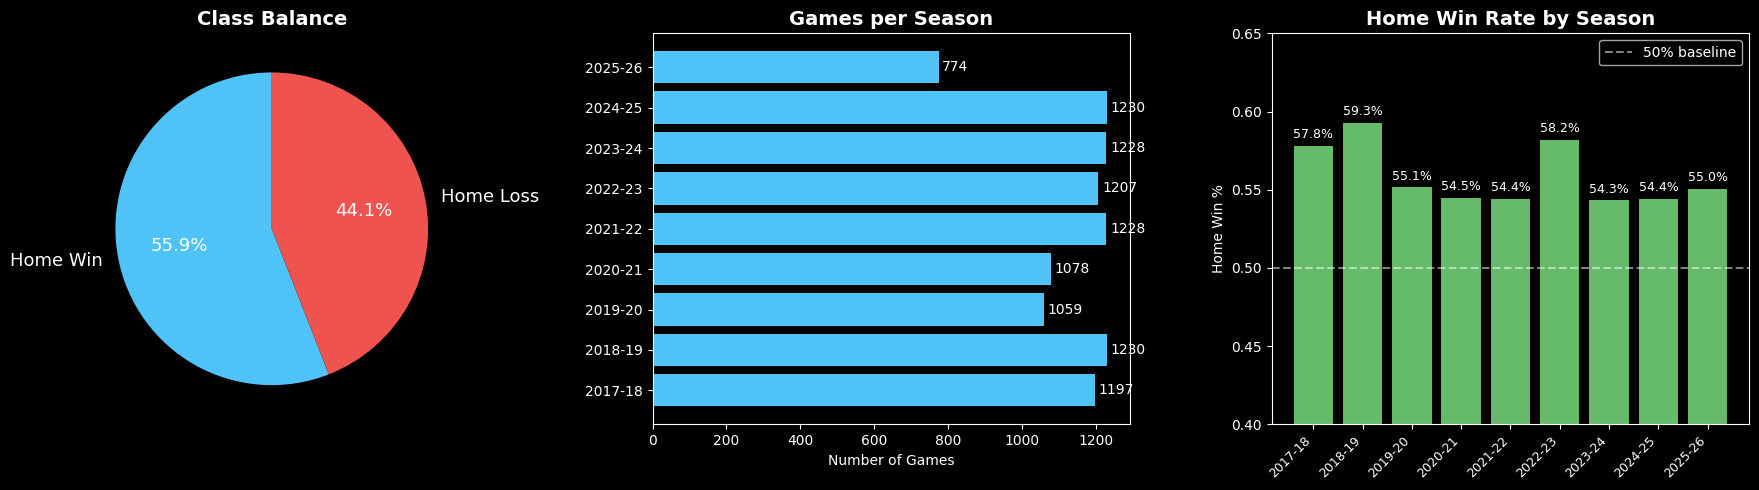

Home advantage is real — home teams win ~56% across all seasons.


In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1) Class balance pie
counts = raw['HOME_W'].value_counts()
axes[0].pie(counts, labels=['Home Win', 'Home Loss'], autopct='%1.1f%%',
            colors=['#4FC3F7', '#EF5350'], startangle=90, textprops={'fontsize': 13})
axes[0].set_title('Class Balance', fontsize=14, fontweight='bold')

# 2) Games per season
season_counts = raw.groupby('SEASON').size()
axes[1].barh(season_counts.index, season_counts.values, color='#4FC3F7')
axes[1].set_xlabel('Number of Games')
axes[1].set_title('Games per Season', fontsize=14, fontweight='bold')
for i, v in enumerate(season_counts.values):
    axes[1].text(v + 10, i, str(v), va='center', fontsize=10)

# 3) Home win rate per season
season_wr = raw.groupby('SEASON')['HOME_W'].mean()
bars = axes[2].bar(range(len(season_wr)), season_wr.values, color='#66BB6A')
axes[2].axhline(0.5, color='white', linestyle='--', alpha=0.5, label='50% baseline')
axes[2].set_xticks(range(len(season_wr)))
axes[2].set_xticklabels(season_wr.index, rotation=45, ha='right', fontsize=9)
axes[2].set_ylabel('Home Win %')
axes[2].set_title('Home Win Rate by Season', fontsize=14, fontweight='bold')
axes[2].set_ylim(0.4, 0.65)
axes[2].legend()
for bar, val in zip(bars, season_wr.values):
    axes[2].text(bar.get_x() + bar.get_width()/2, val + 0.005, f'{val:.1%}', 
                 ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('01_data_overview.png', dpi=150, bbox_inches='tight')
plt.show()
print("Home advantage is real — home teams win ~56% across all seasons.")

## Feature Statistics

Quick look at the distributions and scales of all 27 features.

In [8]:
# Prepare feature matrix
ID_COLS = ['HOME_W', 'SEASON', 'GAME_ID', 'HOME_TEAM_ID', 'AWAY_TEAM_ID']
feature_cols = [c for c in raw.columns if c not in ID_COLS]
X_all = raw[feature_cols]
y_all = raw['HOME_W']

print(f"Feature matrix: {X_all.shape[0]:,} rows × {X_all.shape[1]} features")
print(f"\n── Feature Summary Stats ──")
X_all.describe().T.round(3)

Feature matrix: 10,231 rows × 27 features

── Feature Summary Stats ──


,count,mean,std,min,25%,50%,75%,max
HOME_LAST_GAME_HOME_WIN_PCTG,10231.0,0.540,0.232,0.000,0.400,0.550,0.700,1.000
HOME_LAST_GAME_AWAY_WIN_PCTG,10231.0,0.419,0.212,0.000,0.269,0.429,0.556,1.000
HOME_LAST_GAME_TOTAL_WIN_PCTG,10231.0,0.484,0.190,0.000,0.360,0.500,0.603,1.000
HOME_NUM_REST_DAYS,10231.0,6.438,2.129,1.000,7.000,7.000,7.000,30.000
HOME_IS_BACK_TO_BACK,10231.0,0.017,0.128,0.000,0.000,0.000,0.000,1.000
HOME_LAST_GAME_ROLLING_OE,10231.0,0.563,0.031,0.362,0.543,0.564,0.585,0.709
HOME_LAST_GAME_ROLLING_SCORING_MARGIN,10231.0,-0.122,8.270,-48.000,-5.600,0.000,5.200,35.000
HOME_LAST_GAME_ROLLING_FG_PCT,10231.0,0.467,0.029,0.315,0.447,0.466,0.486,0.661
HOME_LAST_GAME_LAST_3_WINS,10231.0,1.466,0.941,0.000,1.000,1.000,2.000,3.000
AWAY_LAST_GAME_HOME_WIN_PCTG,10231.0,0.542,0.229,0.000,0.400,0.552,0.700,1.000


## Baseline Model Training

Train a `GradientBoostingClassifier` with all 27 features. This is our starting point to beat.

We use stratified split (80/20) to preserve the ~56%/44% class balance.

In [9]:
# ── Baseline Model ────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

print(f"Train: {len(X_train):,}  |  Test: {len(X_test):,}")
print(f"Train home-win rate: {y_train.mean():.3f}  |  Test: {y_test.mean():.3f}")

baseline = GradientBoostingClassifier(
    n_estimators=200, learning_rate=0.05, max_depth=2, subsample=0.8, random_state=42
)
baseline.fit(X_train, y_train)

y_pred = baseline.predict(X_test)
y_proba = baseline.predict_proba(X_test)[:, 1]

print(f"\n{'='*50}")
print(f"  BASELINE ACCURACY:  {accuracy_score(y_test, y_pred):.4f}")
print(f"  Precision:          {precision_score(y_test, y_pred):.4f}")
print(f"  Recall:             {recall_score(y_test, y_pred):.4f}")
print(f"  F1 Score:           {f1_score(y_test, y_pred):.4f}")
print(f"{'='*50}")
print(f"\nNaive baseline (always predict home win): {y_test.mean():.4f}")
print(f"Our model beats naive by: +{accuracy_score(y_test, y_pred) - y_test.mean():.4f}")
print(f"\n── Classification Report ──")
print(classification_report(y_test, y_pred, target_names=['Home Loss', 'Home Win']))

Train: 8,184  |  Test: 2,047
Train home-win rate: 0.560  |  Test: 0.559

  BASELINE ACCURACY:  0.6277
  Precision:          0.6493
  Recall:             0.7275
  F1 Score:           0.6862

Naive baseline (always predict home win): 0.5594
Our model beats naive by: +0.0684

── Classification Report ──
              precision    recall  f1-score   support

   Home Loss       0.59      0.50      0.54       902
    Home Win       0.65      0.73      0.69      1145

    accuracy                           0.63      2047
   macro avg       0.62      0.61      0.61      2047
weighted avg       0.62      0.63      0.62      2047



## Confusion Matrix

Visual breakdown of true vs predicted outcomes.

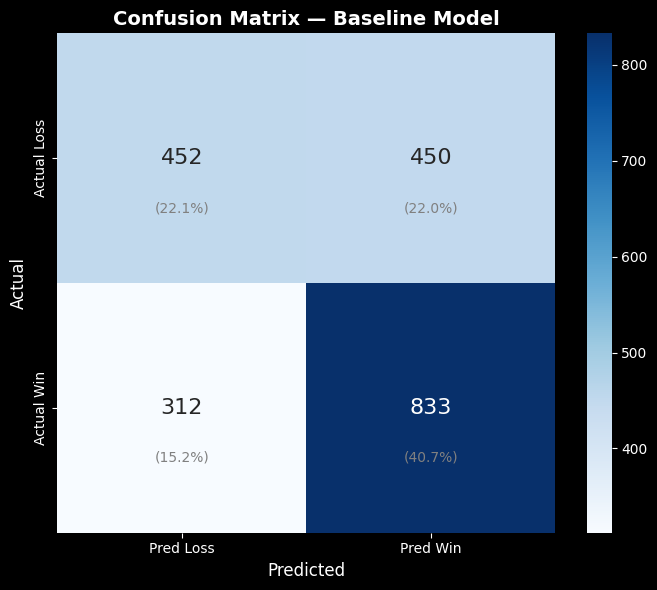

In [10]:
fig, ax = plt.subplots(figsize=(7, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred Loss', 'Pred Win'], 
            yticklabels=['Actual Loss', 'Actual Win'],
            annot_kws={'size': 16}, ax=ax)
ax.set_title('Confusion Matrix — Baseline Model', fontsize=14, fontweight='bold')
ax.set_ylabel('Actual', fontsize=12)
ax.set_xlabel('Predicted', fontsize=12)

# Add percentages
total = cm.sum()
for i in range(2):
    for j in range(2):
        ax.text(j + 0.5, i + 0.7, f'({cm[i][j]/total:.1%})', 
                ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()
plt.savefig('02_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## Feature Importance

Which features does the model rely on most? This tells us what stats actually matter for predicting NBA game outcomes.

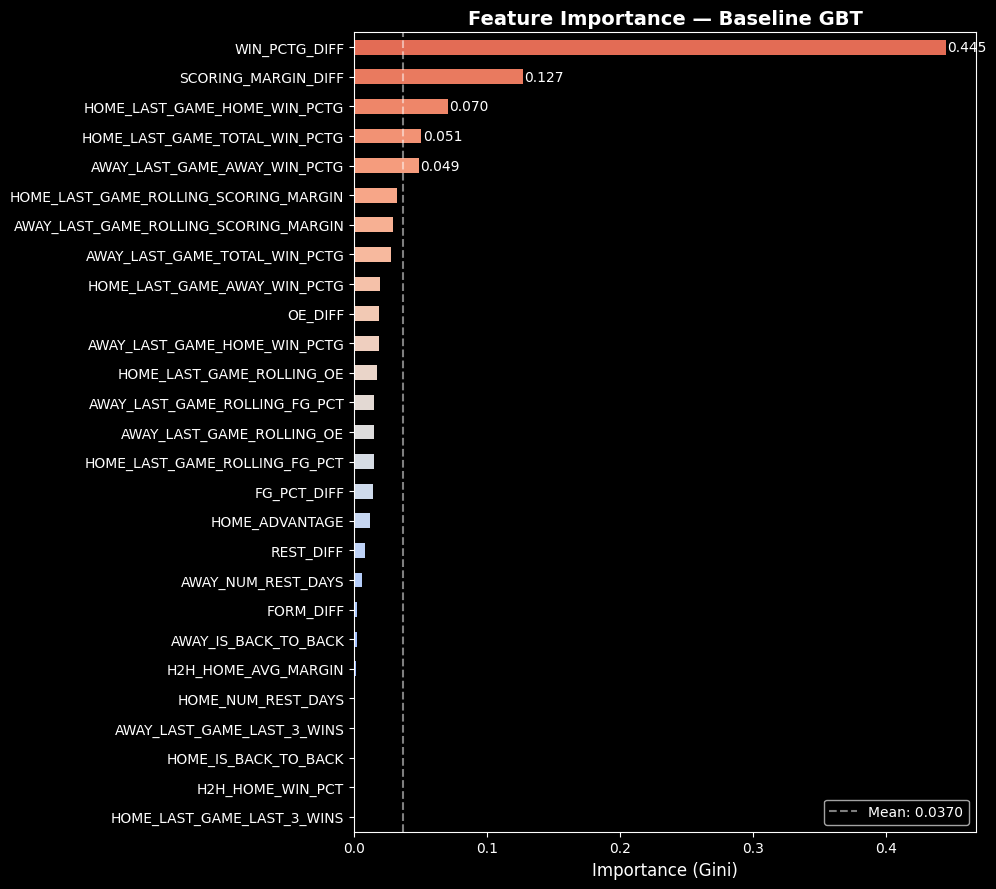


── Top 10 Features ──
   1. WIN_PCTG_DIFF                                 0.4451
   2. SCORING_MARGIN_DIFF                           0.1271
   3. HOME_LAST_GAME_HOME_WIN_PCTG                  0.0704
   4. HOME_LAST_GAME_TOTAL_WIN_PCTG                 0.0506
   5. AWAY_LAST_GAME_AWAY_WIN_PCTG                  0.0486
   6. HOME_LAST_GAME_ROLLING_SCORING_MARGIN         0.0325
   7. AWAY_LAST_GAME_ROLLING_SCORING_MARGIN         0.0295
   8. AWAY_LAST_GAME_TOTAL_WIN_PCTG                 0.0278
   9. HOME_LAST_GAME_AWAY_WIN_PCTG                  0.0192
  10. OE_DIFF                                       0.0190

── Bottom 5 (least useful) ──
      HOME_LAST_GAME_LAST_3_WINS                    0.0000
      H2H_HOME_WIN_PCT                              0.0005
      HOME_IS_BACK_TO_BACK                          0.0007
      AWAY_LAST_GAME_LAST_3_WINS                    0.0009
      HOME_NUM_REST_DAYS                            0.0009


In [11]:
# ── Feature Importance (Gini / mean decrease in impurity) ────────
importances = pd.Series(baseline.feature_importances_, index=feature_cols).sort_values()

fig, ax = plt.subplots(figsize=(10, 9))
colors = plt.cm.coolwarm(np.linspace(0.15, 0.85, len(importances)))
importances.plot.barh(ax=ax, color=colors)
ax.set_xlabel('Importance (Gini)', fontsize=12)
ax.set_title('Feature Importance — Baseline GBT', fontsize=14, fontweight='bold')
ax.axvline(importances.mean(), color='white', linestyle='--', alpha=0.5, label=f'Mean: {importances.mean():.4f}')
ax.legend()

# Annotate top 5
for idx, (feat, val) in enumerate(importances.tail(5).items()):
    ax.text(val + 0.001, len(importances) - 5 + idx, f'{val:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('03_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n── Top 10 Features ──")
for i, (feat, val) in enumerate(importances.tail(10)[::-1].items(), 1):
    print(f"  {i:2d}. {feat:<45s} {val:.4f}")

print(f"\n── Bottom 5 (least useful) ──")
for feat, val in importances.head(5).items():
    print(f"      {feat:<45s} {val:.4f}")

## Feature Correlations

Highly correlated features are redundant — they can add noise without adding information. Let's identify clusters of correlated features.

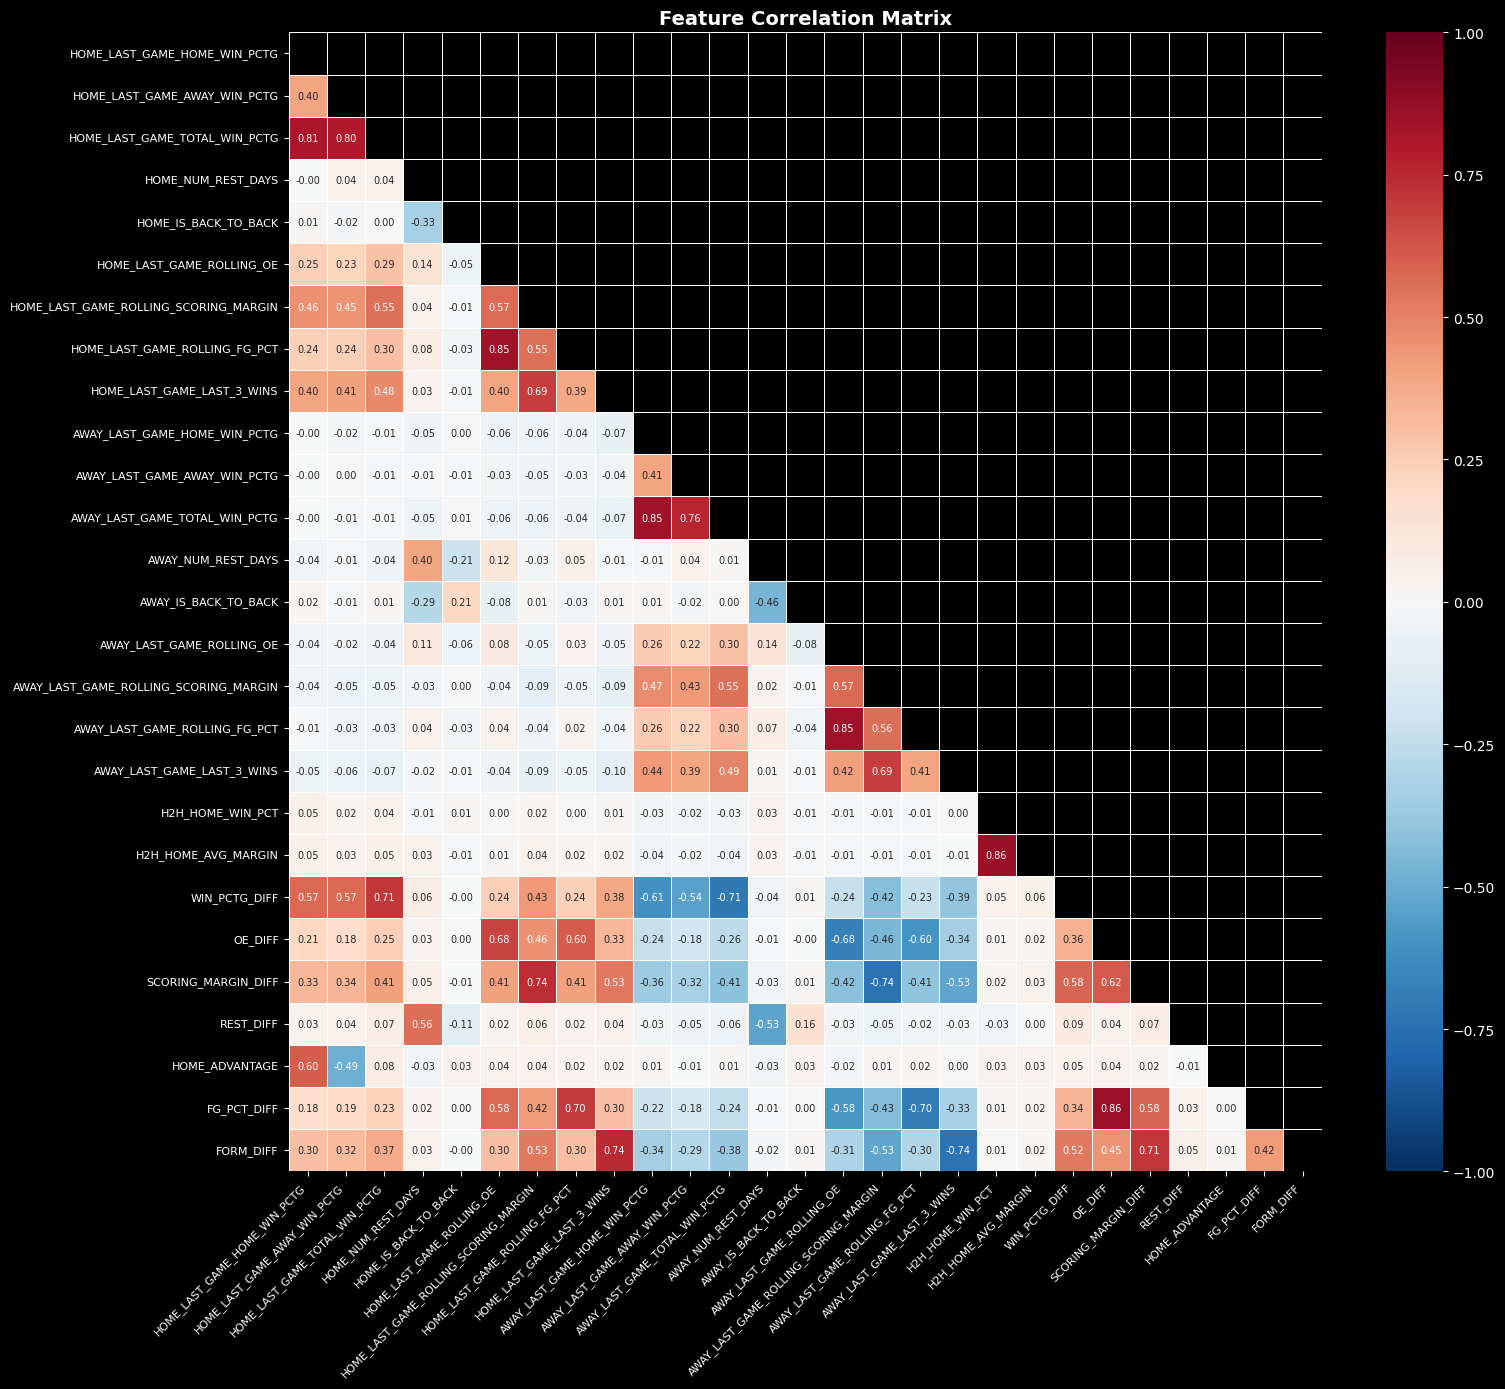


── Highly Correlated Pairs (|r| > 0.7) ──
  H2H_HOME_WIN_PCT                         ↔ H2H_HOME_AVG_MARGIN                       r=0.862
  OE_DIFF                                  ↔ FG_PCT_DIFF                               r=0.855
  HOME_LAST_GAME_ROLLING_OE                ↔ HOME_LAST_GAME_ROLLING_FG_PCT             r=0.851
  AWAY_LAST_GAME_HOME_WIN_PCTG             ↔ AWAY_LAST_GAME_TOTAL_WIN_PCTG             r=0.849
  AWAY_LAST_GAME_ROLLING_OE                ↔ AWAY_LAST_GAME_ROLLING_FG_PCT             r=0.846
  HOME_LAST_GAME_HOME_WIN_PCTG             ↔ HOME_LAST_GAME_TOTAL_WIN_PCTG             r=0.813
  HOME_LAST_GAME_AWAY_WIN_PCTG             ↔ HOME_LAST_GAME_TOTAL_WIN_PCTG             r=0.799
  AWAY_LAST_GAME_AWAY_WIN_PCTG             ↔ AWAY_LAST_GAME_TOTAL_WIN_PCTG             r=0.758
  HOME_LAST_GAME_LAST_3_WINS               ↔ FORM_DIFF                                 r=0.743
  HOME_LAST_GAME_ROLLING_SCORING_MARGIN    ↔ SCORING_MARGIN_DIFF                       r=0.742
  AWAY_

In [12]:
# ── Correlation Heatmap ──────────────────────────────────────────
corr = X_all.corr()

fig, ax = plt.subplots(figsize=(16, 14))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            vmin=-1, vmax=1, ax=ax, annot_kws={'size': 7},
            linewidths=0.5)
ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig('04_correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# Find highly correlated pairs
print("\n── Highly Correlated Pairs (|r| > 0.7) ──")
pairs = []
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        r = corr.iloc[i, j]
        if abs(r) > 0.7:
            pairs.append((corr.columns[i], corr.columns[j], r))
pairs.sort(key=lambda x: abs(x[2]), reverse=True)
for f1, f2, r in pairs:
    print(f"  {f1:<40s} ↔ {f2:<40s}  r={r:.3f}")

## Correlation with Target

Which features correlate most strongly with home wins?

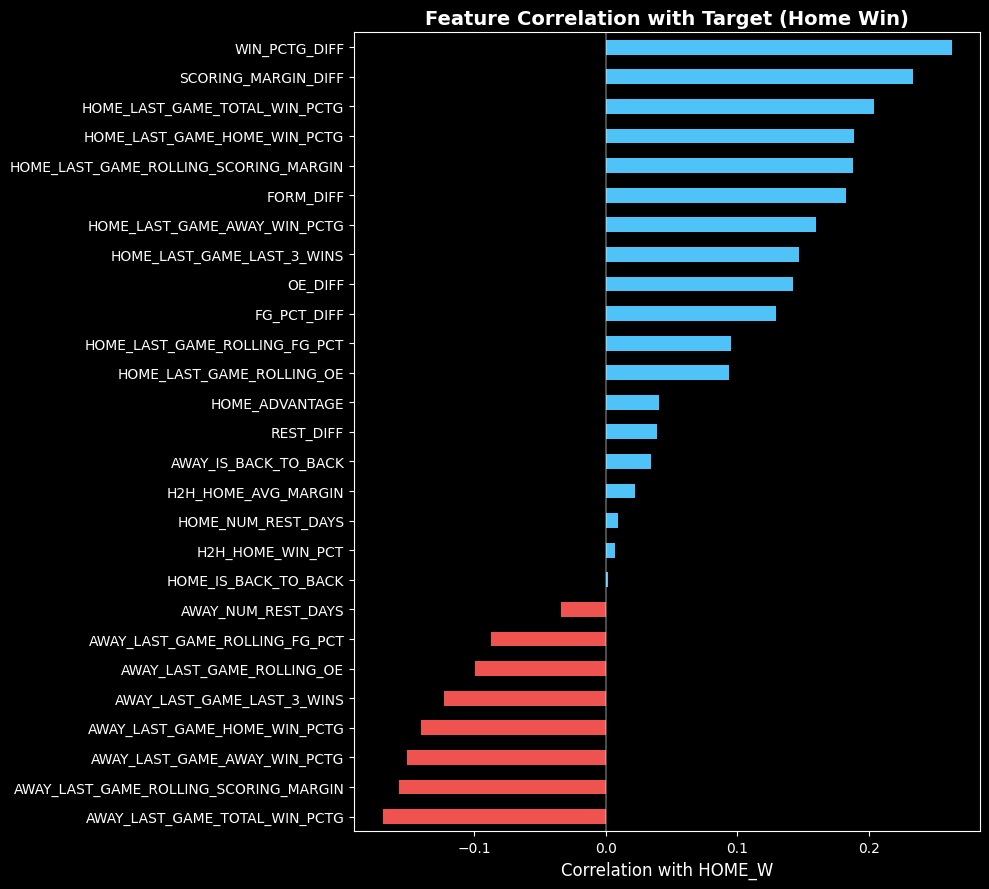


── Top positive correlations (home team winning) ──
  WIN_PCTG_DIFF                                 r = +0.2629
  SCORING_MARGIN_DIFF                           r = +0.2336
  HOME_LAST_GAME_TOTAL_WIN_PCTG                 r = +0.2041
  HOME_LAST_GAME_HOME_WIN_PCTG                  r = +0.1888
  HOME_LAST_GAME_ROLLING_SCORING_MARGIN         r = +0.1881

── Top negative correlations (away team winning) ──
  AWAY_LAST_GAME_TOTAL_WIN_PCTG                 r = -0.1697
  AWAY_LAST_GAME_ROLLING_SCORING_MARGIN         r = -0.1573
  AWAY_LAST_GAME_AWAY_WIN_PCTG                  r = -0.1508
  AWAY_LAST_GAME_HOME_WIN_PCTG                  r = -0.1405
  AWAY_LAST_GAME_LAST_3_WINS                    r = -0.1229


In [13]:
# ── Target Correlation ───────────────────────────────────────────
target_corr = X_all.corrwith(y_all).sort_values()

fig, ax = plt.subplots(figsize=(10, 9))
colors = ['#EF5350' if v < 0 else '#4FC3F7' for v in target_corr]
target_corr.plot.barh(ax=ax, color=colors)
ax.set_xlabel('Correlation with HOME_W', fontsize=12)
ax.set_title('Feature Correlation with Target (Home Win)', fontsize=14, fontweight='bold')
ax.axvline(0, color='white', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.savefig('05_target_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n── Top positive correlations (home team winning) ──")
for feat, val in target_corr.tail(5)[::-1].items():
    print(f"  {feat:<45s} r = {val:+.4f}")
print(f"\n── Top negative correlations (away team winning) ──")
for feat, val in target_corr.head(5).items():
    print(f"  {feat:<45s} r = {val:+.4f}")

## Drop-One-Out Ablation Study

Remove one feature at a time and retrain. If accuracy goes **up** when a feature is removed, that feature is hurting us — it's noise.

This is the gold standard for understanding feature value.

In [14]:
# ── Drop-One-Out Analysis ────────────────────────────────────────
baseline_acc = accuracy_score(y_test, y_pred)
drop_results = {}

print(f"Baseline accuracy (all {len(feature_cols)} features): {baseline_acc:.4f}")
print(f"\nRunning ablation study... (this takes ~2 min)")

for feat in feature_cols:
    cols_without = [c for c in feature_cols if c != feat]
    m = GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.05, max_depth=2, subsample=0.8, random_state=42
    )
    m.fit(X_train[cols_without], y_train)
    acc = accuracy_score(y_test, m.predict(X_test[cols_without]))
    drop_results[feat] = acc
    delta = acc - baseline_acc
    marker = "⬆️" if delta > 0.001 else ("⬇️" if delta < -0.001 else "➖")
    print(f"  Drop {feat:<42s} → {acc:.4f}  ({delta:+.4f}) {marker}")

drop_series = pd.Series(drop_results).sort_values() - baseline_acc
print(f"\n✅ Ablation complete.")

Baseline accuracy (all 27 features): 0.6277

Running ablation study... (this takes ~2 min)
  Drop HOME_LAST_GAME_HOME_WIN_PCTG               → 0.6253  (-0.0024) ⬇️
  Drop HOME_LAST_GAME_AWAY_WIN_PCTG               → 0.6268  (-0.0010) ➖
  Drop HOME_LAST_GAME_TOTAL_WIN_PCTG              → 0.6302  (+0.0024) ⬆️
  Drop HOME_NUM_REST_DAYS                         → 0.6263  (-0.0015) ⬇️
  Drop HOME_IS_BACK_TO_BACK                       → 0.6297  (+0.0020) ⬆️
  Drop HOME_LAST_GAME_ROLLING_OE                  → 0.6321  (+0.0044) ⬆️
  Drop HOME_LAST_GAME_ROLLING_SCORING_MARGIN      → 0.6253  (-0.0024) ⬇️
  Drop HOME_LAST_GAME_ROLLING_FG_PCT              → 0.6287  (+0.0010) ➖
  Drop HOME_LAST_GAME_LAST_3_WINS                 → 0.6292  (+0.0015) ⬆️
  Drop AWAY_LAST_GAME_HOME_WIN_PCTG               → 0.6317  (+0.0039) ⬆️
  Drop AWAY_LAST_GAME_AWAY_WIN_PCTG               → 0.6238  (-0.0039) ⬇️
  Drop AWAY_LAST_GAME_TOTAL_WIN_PCTG              → 0.6321  (+0.0044) ⬆️
  Drop AWAY_NUM_REST_DAYS          

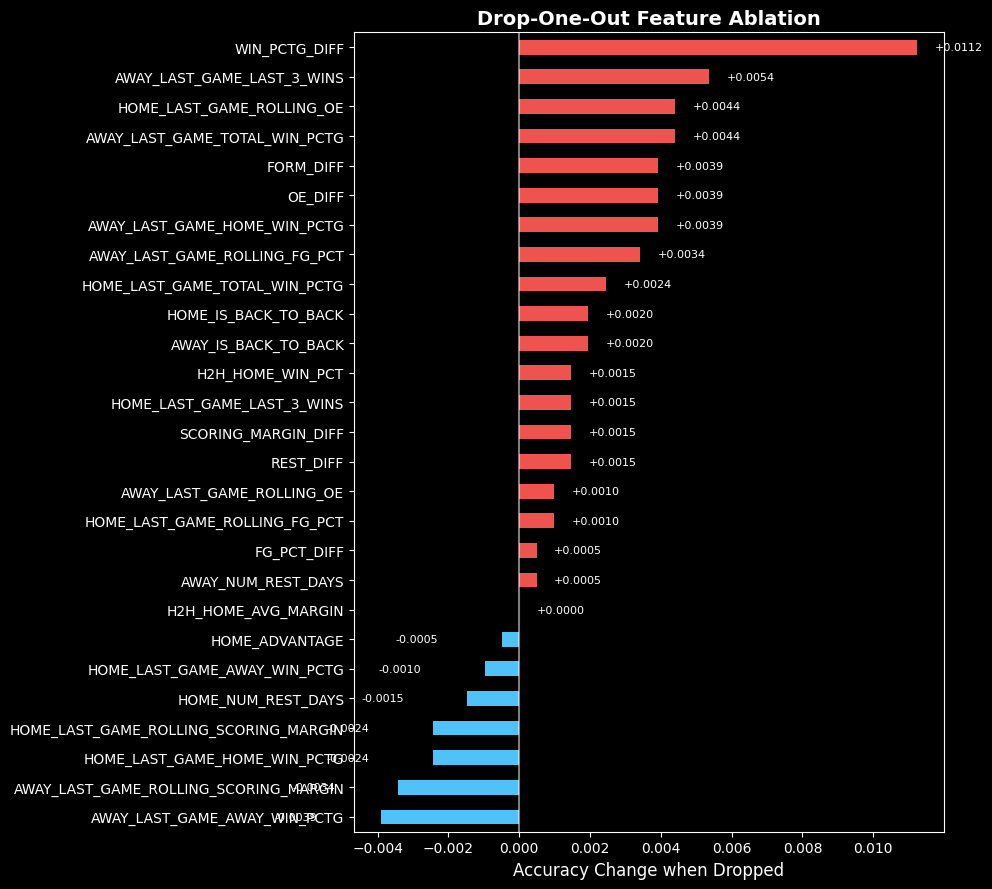


🔴 Features that HURT accuracy when included (15):
   - REST_DIFF (accuracy improves by +0.0015 when dropped)
   - SCORING_MARGIN_DIFF (accuracy improves by +0.0015 when dropped)
   - HOME_LAST_GAME_LAST_3_WINS (accuracy improves by +0.0015 when dropped)
   - H2H_HOME_WIN_PCT (accuracy improves by +0.0015 when dropped)
   - AWAY_IS_BACK_TO_BACK (accuracy improves by +0.0020 when dropped)
   - HOME_IS_BACK_TO_BACK (accuracy improves by +0.0020 when dropped)
   - HOME_LAST_GAME_TOTAL_WIN_PCTG (accuracy improves by +0.0024 when dropped)
   - AWAY_LAST_GAME_ROLLING_FG_PCT (accuracy improves by +0.0034 when dropped)
   - AWAY_LAST_GAME_HOME_WIN_PCTG (accuracy improves by +0.0039 when dropped)
   - OE_DIFF (accuracy improves by +0.0039 when dropped)
   - FORM_DIFF (accuracy improves by +0.0039 when dropped)
   - AWAY_LAST_GAME_TOTAL_WIN_PCTG (accuracy improves by +0.0044 when dropped)
   - HOME_LAST_GAME_ROLLING_OE (accuracy improves by +0.0044 when dropped)
   - AWAY_LAST_GAME_LAST_3_WINS (

In [15]:
# ── Ablation Chart ───────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 9))
colors = ['#EF5350' if v > 0 else '#4FC3F7' for v in drop_series]
drop_series.plot.barh(ax=ax, color=colors)
ax.set_xlabel('Accuracy Change when Dropped', fontsize=12)
ax.set_title('Drop-One-Out Feature Ablation', fontsize=14, fontweight='bold')
ax.axvline(0, color='white', linestyle='-', alpha=0.5)

# Annotate
for i, (feat, val) in enumerate(drop_series.items()):
    ax.text(val + (0.0005 if val >= 0 else -0.003), i, f'{val:+.4f}', va='center', fontsize=8)

plt.tight_layout()
plt.savefig('06_ablation_study.png', dpi=150, bbox_inches='tight')
plt.show()

# Identify features to drop
hurt_features = [f for f, v in drop_series.items() if v > 0.001]
print(f"\n🔴 Features that HURT accuracy when included ({len(hurt_features)}):")
for f in hurt_features:
    print(f"   - {f} (accuracy improves by {drop_series[f]:+.4f} when dropped)")

useless_features = [f for f, v in drop_series.items() if abs(v) < 0.001]
print(f"\n⚪ Features with negligible impact ({len(useless_features)}):")
for f in useless_features:
    print(f"   - {f} (Δ = {drop_series[f]:+.4f})")

## Optimized Model — Dropping Harmful Features

Now let's retrain without the features that hurt accuracy. Less noise = better signal.

In [16]:
# ── Optimized Model ──────────────────────────────────────────────
# Drop features that increased accuracy when removed (they add noise)
keep_cols = [c for c in feature_cols if c not in hurt_features]
print(f"Dropped {len(hurt_features)} harmful features")
print(f"Keeping {len(keep_cols)} features: {keep_cols}")

opt_model = GradientBoostingClassifier(
    n_estimators=200, learning_rate=0.05, max_depth=2, subsample=0.8, random_state=42
)
opt_model.fit(X_train[keep_cols], y_train)
y_pred_opt = opt_model.predict(X_test[keep_cols])
y_proba_opt = opt_model.predict_proba(X_test[keep_cols])[:, 1]

opt_acc = accuracy_score(y_test, y_pred_opt)
print(f"\n{'='*50}")
print(f"  BASELINE ACCURACY:   {baseline_acc:.4f}")
print(f"  OPTIMIZED ACCURACY:  {opt_acc:.4f}")
print(f"  IMPROVEMENT:         {opt_acc - baseline_acc:+.4f}")
print(f"{'='*50}")
print(f"\n── Classification Report (Optimized) ──")
print(classification_report(y_test, y_pred_opt, target_names=['Home Loss', 'Home Win']))

Dropped 15 harmful features
Keeping 12 features: ['HOME_LAST_GAME_HOME_WIN_PCTG', 'HOME_LAST_GAME_AWAY_WIN_PCTG', 'HOME_NUM_REST_DAYS', 'HOME_LAST_GAME_ROLLING_SCORING_MARGIN', 'HOME_LAST_GAME_ROLLING_FG_PCT', 'AWAY_LAST_GAME_AWAY_WIN_PCTG', 'AWAY_NUM_REST_DAYS', 'AWAY_LAST_GAME_ROLLING_OE', 'AWAY_LAST_GAME_ROLLING_SCORING_MARGIN', 'H2H_HOME_AVG_MARGIN', 'HOME_ADVANTAGE', 'FG_PCT_DIFF']

  BASELINE ACCURACY:   0.6277
  OPTIMIZED ACCURACY:  0.6326
  IMPROVEMENT:         +0.0049

── Classification Report (Optimized) ──
              precision    recall  f1-score   support

   Home Loss       0.61      0.48      0.53       902
    Home Win       0.65      0.75      0.70      1145

    accuracy                           0.63      2047
   macro avg       0.63      0.62      0.62      2047
weighted avg       0.63      0.63      0.63      2047



## Hyperparameter Tuning — Grid Search

Let's try different configurations to squeeze out more accuracy.

In [17]:
# ── Hyperparameter Grid Search ───────────────────────────────────
from sklearn.model_selection import cross_val_score

configs = [
    {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 2, 'subsample': 0.8},
    {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 2, 'subsample': 0.8},
    {'n_estimators': 300, 'learning_rate': 0.03, 'max_depth': 2, 'subsample': 0.8},
    {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 3, 'subsample': 0.8},
    {'n_estimators': 200, 'learning_rate': 0.1,  'max_depth': 2, 'subsample': 0.8},
    {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 2, 'subsample': 0.7},
    {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 2, 'subsample': 0.9},
    {'n_estimators': 400, 'learning_rate': 0.03, 'max_depth': 2, 'subsample': 0.8},
    {'n_estimators': 500, 'learning_rate': 0.02, 'max_depth': 2, 'subsample': 0.8},
    {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 0.8},
]

print(f"Testing {len(configs)} configurations with 5-fold cross-validation on optimized features...")
print(f"Features used: {len(keep_cols)}\n")

results = []
for i, cfg in enumerate(configs):
    m = GradientBoostingClassifier(**cfg, random_state=42)
    scores = cross_val_score(m, X_all[keep_cols], y_all, cv=5, scoring='accuracy')
    results.append({**cfg, 'mean_cv': scores.mean(), 'std_cv': scores.std()})
    print(f"  [{i+1:2d}/{len(configs)}] n={cfg['n_estimators']:3d}  lr={cfg['learning_rate']:.2f}  "
          f"depth={cfg['max_depth']}  sub={cfg['subsample']}  →  "
          f"CV acc: {scores.mean():.4f} ± {scores.std():.4f}")

results_df = pd.DataFrame(results).sort_values('mean_cv', ascending=False)
print(f"\n── Best Configuration ──")
best = results_df.iloc[0]
print(f"  n_estimators: {int(best['n_estimators'])}")
print(f"  learning_rate: {best['learning_rate']}")
print(f"  max_depth: {int(best['max_depth'])}")
print(f"  subsample: {best['subsample']}")
print(f"  CV Accuracy: {best['mean_cv']:.4f} ± {best['std_cv']:.4f}")

Testing 10 configurations with 5-fold cross-validation on optimized features...
Features used: 12

  [ 1/10] n=150  lr=0.05  depth=2  sub=0.8  →  CV acc: 0.6319 ± 0.0221
  [ 2/10] n=200  lr=0.05  depth=2  sub=0.8  →  CV acc: 0.6329 ± 0.0239
  [ 3/10] n=300  lr=0.03  depth=2  sub=0.8  →  CV acc: 0.6359 ± 0.0226
  [ 4/10] n=300  lr=0.05  depth=3  sub=0.8  →  CV acc: 0.6316 ± 0.0167
  [ 5/10] n=200  lr=0.10  depth=2  sub=0.8  →  CV acc: 0.6321 ± 0.0184
  [ 6/10] n=200  lr=0.05  depth=2  sub=0.7  →  CV acc: 0.6334 ± 0.0209
  [ 7/10] n=300  lr=0.05  depth=2  sub=0.9  →  CV acc: 0.6339 ± 0.0231
  [ 8/10] n=400  lr=0.03  depth=2  sub=0.8  →  CV acc: 0.6350 ± 0.0217
  [ 9/10] n=500  lr=0.02  depth=2  sub=0.8  →  CV acc: 0.6328 ± 0.0225
  [10/10] n=200  lr=0.05  depth=4  sub=0.8  →  CV acc: 0.6320 ± 0.0185

── Best Configuration ──
  n_estimators: 300
  learning_rate: 0.03
  max_depth: 2
  subsample: 0.8
  CV Accuracy: 0.6359 ± 0.0226


## Best Tuned Model — Final Evaluation

Train the best hyperparameter config on the optimized feature set and evaluate on the held-out test set.

In [18]:
# ── Train Best Config ────────────────────────────────────────────
best_params = {
    'n_estimators': int(best['n_estimators']),
    'learning_rate': best['learning_rate'],
    'max_depth': int(best['max_depth']),
    'subsample': best['subsample'],
    'random_state': 42
}
print(f"Best params: {best_params}")

best_model = GradientBoostingClassifier(**best_params)
best_model.fit(X_train[keep_cols], y_train)
y_pred_best = best_model.predict(X_test[keep_cols])
y_proba_best = best_model.predict_proba(X_test[keep_cols])[:, 1]

best_acc = accuracy_score(y_test, y_pred_best)

print(f"\n{'='*55}")
print(f"  BASELINE (all features, default):   {baseline_acc:.4f}")
print(f"  OPTIMIZED (fewer features):         {opt_acc:.4f}")
print(f"  BEST TUNED:                         {best_acc:.4f}")
print(f"  TOTAL IMPROVEMENT:                  {best_acc - baseline_acc:+.4f}")
print(f"{'='*55}")
print(f"\n── Classification Report (Best Tuned) ──")
print(classification_report(y_test, y_pred_best, target_names=['Home Loss', 'Home Win']))

Best params: {'n_estimators': 300, 'learning_rate': np.float64(0.03), 'max_depth': 2, 'subsample': np.float64(0.8), 'random_state': 42}

  BASELINE (all features, default):   0.6277
  OPTIMIZED (fewer features):         0.6326
  BEST TUNED:                         0.6292
  TOTAL IMPROVEMENT:                  +0.0015

── Classification Report (Best Tuned) ──
              precision    recall  f1-score   support

   Home Loss       0.60      0.47      0.53       902
    Home Win       0.64      0.75      0.69      1145

    accuracy                           0.63      2047
   macro avg       0.62      0.61      0.61      2047
weighted avg       0.63      0.63      0.62      2047



## Per-Season Accuracy Breakdown

Does the model perform consistently across seasons, or does it struggle in certain years? This is crucial for understanding generalizability.

         games  correct  accuracy
SEASON                           
2017-18    245      162    0.6612
2018-19    245      174    0.7102
2019-20    202      125    0.6188
2020-21    205      126    0.6146
2021-22    252      149    0.5913
2022-23    237      150    0.6329
2023-24    259      151    0.5830
2024-25    230      156    0.6783
2025-26    172       95    0.5523


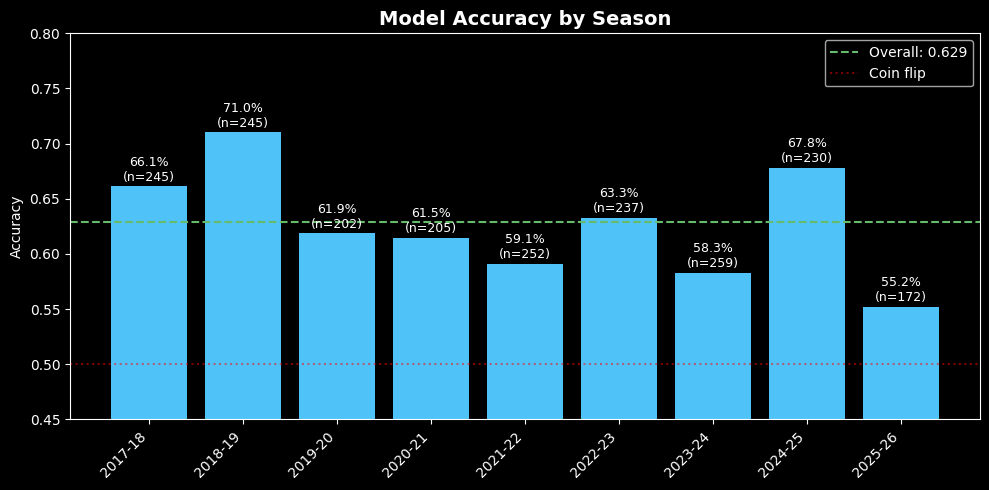

In [19]:
# ── Per-Season Accuracy ──────────────────────────────────────────
test_data = raw.iloc[X_test.index].copy()
test_data['pred'] = y_pred_best
test_data['correct'] = (test_data['pred'] == test_data['HOME_W']).astype(int)

season_acc = test_data.groupby('SEASON').agg(
    games=('correct', 'count'),
    correct=('correct', 'sum'),
    accuracy=('correct', 'mean')
).round(4)
print(season_acc.to_string())

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(range(len(season_acc)), season_acc['accuracy'], color='#4FC3F7')
ax.axhline(best_acc, color='#66BB6A', linestyle='--', label=f'Overall: {best_acc:.3f}')
ax.axhline(0.5, color='red', linestyle=':', alpha=0.5, label='Coin flip')
ax.set_xticks(range(len(season_acc)))
ax.set_xticklabels(season_acc.index, rotation=45, ha='right')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy by Season', fontsize=14, fontweight='bold')
ax.set_ylim(0.45, 0.80)
ax.legend()

for bar, (_, row) in zip(bars, season_acc.iterrows()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f'{row["accuracy"]:.1%}\n(n={int(row["games"])})', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('07_season_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

## Confidence Calibration

When the model says 70% chance of a home win, does the home team **actually** win ~70% of the time? Good calibration = trustworthy predictions.

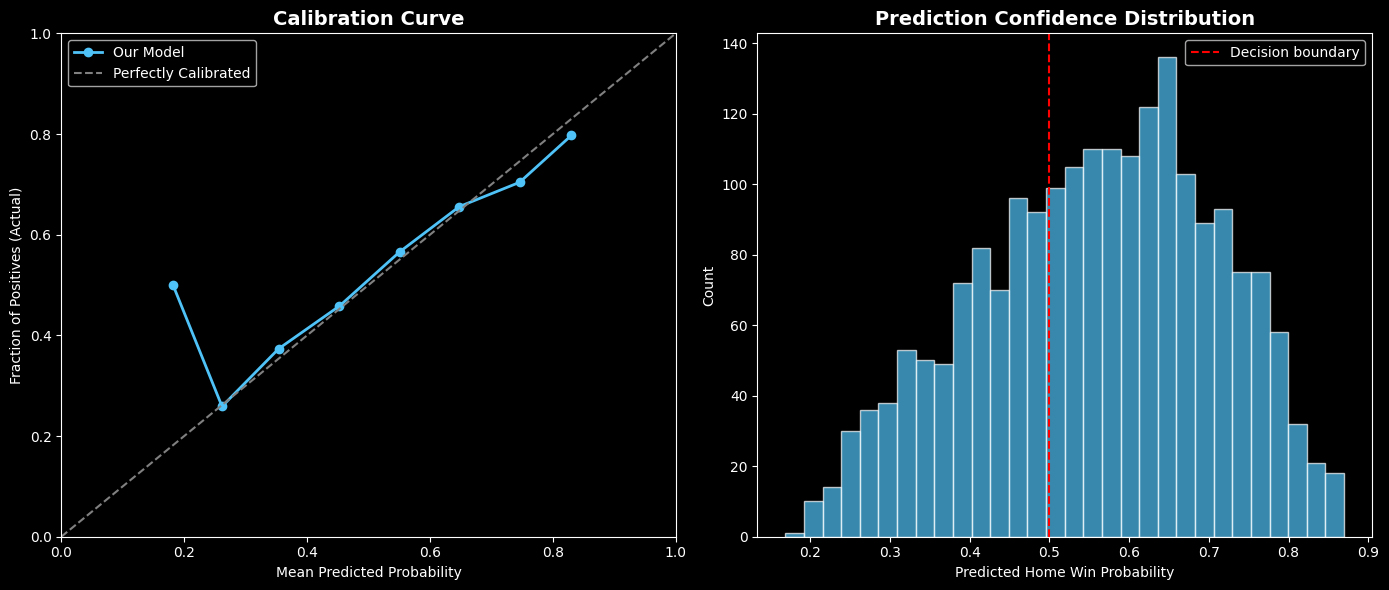


── Accuracy by Model Confidence ──
  Confidence 50%-55%:  48.3% accurate  (n=422)
  Confidence 55%-60%:  63.2% accurate  (n=394)
  Confidence 60%-65%:  60.2% accurate  (n=384)
  Confidence 65%-70%:  69.7% accurate  (n=343)
  Confidence 70%-75%:  69.0% accurate  (n=255)
  Confidence 75%-100%:  75.9% accurate  (n=249)


In [21]:
# ── Confidence Calibration ───────────────────────────────────────
from sklearn.calibration import calibration_curve

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1) Calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_proba_best, n_bins=10, strategy='uniform')
axes[0].plot(prob_pred, prob_true, 'o-', color='#4FC3F7', linewidth=2, label='Our Model')
axes[0].plot([0, 1], [0, 1], '--', color='gray', label='Perfectly Calibrated')
axes[0].set_xlabel('Mean Predicted Probability')
axes[0].set_ylabel('Fraction of Positives (Actual)')
axes[0].set_title('Calibration Curve', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1)

# 2) Prediction confidence distribution
axes[1].hist(y_proba_best, bins=30, color='#4FC3F7', alpha=0.7, edgecolor='white')
axes[1].axvline(0.5, color='red', linestyle='--', label='Decision boundary')
axes[1].set_xlabel('Predicted Home Win Probability')
axes[1].set_ylabel('Count')
axes[1].set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.savefig('08_calibration.png', dpi=150, bbox_inches='tight')
plt.show()

# Accuracy by confidence bucket
print("\n── Accuracy by Model Confidence ──")
test_conf = pd.DataFrame({'proba': y_proba_best, 'actual': y_test.values})
test_conf['confidence'] = test_conf['proba'].apply(lambda p: max(p, 1-p))  # distance from 0.5
test_conf['pred'] = (test_conf['proba'] >= 0.5).astype(int)
test_conf['correct'] = (test_conf['pred'] == test_conf['actual']).astype(int)

bins = [(0.5, 0.55), (0.55, 0.6), (0.6, 0.65), (0.65, 0.7), (0.7, 0.75), (0.75, 1.0)]
for lo, hi in bins:
    mask = (test_conf['confidence'] >= lo) & (test_conf['confidence'] < hi)
    n = mask.sum()
    if n > 0:
        acc = test_conf.loc[mask, 'correct'].mean()
        print(f"  Confidence {lo:.0%}-{hi:.0%}:  {acc:.1%} accurate  (n={n})")
    else:
        print(f"  Confidence {lo:.0%}-{hi:.0%}:  no samples")

## Comparison with Other Algorithms

Let's see how GradientBoosting stacks up against Random Forest, Logistic Regression, and others. Fair fight — same features, same split.

Training 5 models on 12 features...

  Gradient Boosting (tuned)      → Accuracy: 0.6292  F1: 0.6946
  Random Forest                  → Accuracy: 0.6141  F1: 0.6722


/Users/akashkothari/Desktop/cxc/backend/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


  AdaBoost                       → Accuracy: 0.6190  F1: 0.6824
  Logistic Regression            → Accuracy: 0.6136  F1: 0.6852
  KNN (k=15)                     → Accuracy: 0.5681  F1: 0.6341


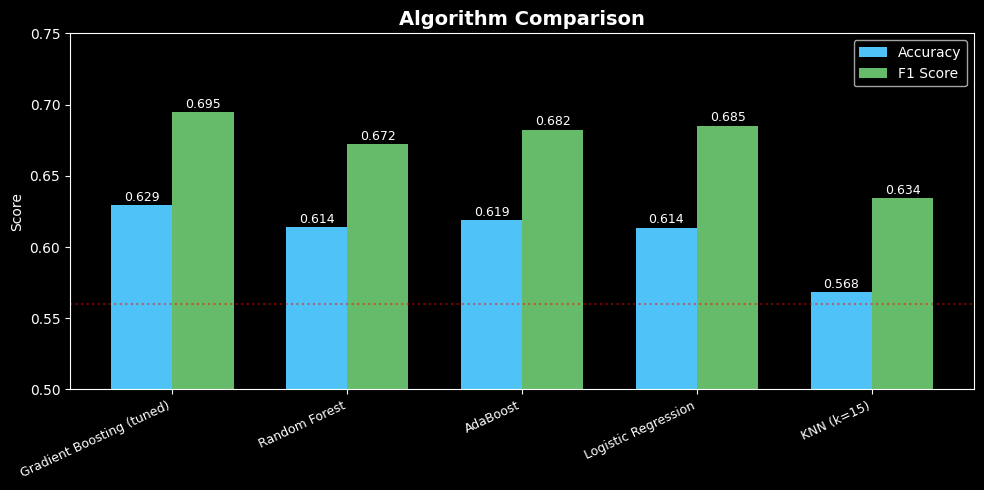

In [22]:
# ── Algorithm Comparison ─────────────────────────────────────────
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

models_to_test = {
    'Gradient Boosting (tuned)': GradientBoostingClassifier(**best_params),
    'Random Forest':            RandomForestClassifier(n_estimators=200, random_state=42),
    'AdaBoost':                 AdaBoostClassifier(n_estimators=200, random_state=42),
    'Logistic Regression':      LogisticRegression(max_iter=1000, random_state=42),
    'KNN (k=15)':               KNeighborsClassifier(n_neighbors=15),
}

algo_results = {}
print(f"Training {len(models_to_test)} models on {len(keep_cols)} features...\n")

for name, model in models_to_test.items():
    model.fit(X_train[keep_cols], y_train)
    y_p = model.predict(X_test[keep_cols])
    acc = accuracy_score(y_test, y_p)
    f1 = f1_score(y_test, y_p)
    algo_results[name] = {'accuracy': acc, 'f1': f1}
    print(f"  {name:<30s} → Accuracy: {acc:.4f}  F1: {f1:.4f}")

# Chart
fig, ax = plt.subplots(figsize=(10, 5))
names = list(algo_results.keys())
accs = [v['accuracy'] for v in algo_results.values()]
f1s = [v['f1'] for v in algo_results.values()]

x = np.arange(len(names))
width = 0.35
bars1 = ax.bar(x - width/2, accs, width, label='Accuracy', color='#4FC3F7')
bars2 = ax.bar(x + width/2, f1s, width, label='F1 Score', color='#66BB6A')

ax.set_ylabel('Score')
ax.set_title('Algorithm Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(names, rotation=25, ha='right', fontsize=9)
ax.set_ylim(0.5, 0.75)
ax.legend()
ax.axhline(0.56, color='red', linestyle=':', alpha=0.5, label='Naive (always home)')

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.003,
            f'{bar.get_height():.3f}', ha='center', fontsize=9)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.003,
            f'{bar.get_height():.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('09_algorithm_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Temporal Validation — Train on Past, Predict the Future

The real test: train on seasons 2017-2024, predict the 2024-25 and 2025-26 seasons. This simulates how the model would perform in production on games it has never seen.

In [24]:
# ── Temporal Split ───────────────────────────────────────────────
# Train on older seasons, test on most recent ones
recent_seasons = ['2024-25', '2025-26']
train_mask = ~raw['SEASON'].isin(recent_seasons)
test_mask = raw['SEASON'].isin(recent_seasons)

X_tr_temp = raw.loc[train_mask, keep_cols]
y_tr_temp = raw.loc[train_mask, 'HOME_W']
X_te_temp = raw.loc[test_mask, keep_cols]
y_te_temp = raw.loc[test_mask, 'HOME_W']

print(f"Temporal train: {len(X_tr_temp):,} games ({sorted(raw.loc[train_mask, 'SEASON'].unique())})")
print(f"Temporal test:  {len(X_te_temp):,} games ({sorted(raw.loc[test_mask, 'SEASON'].unique())})")

temp_model = GradientBoostingClassifier(**best_params)
temp_model.fit(X_tr_temp, y_tr_temp)
y_pred_temp = temp_model.predict(X_te_temp)

temp_acc = accuracy_score(y_te_temp, y_pred_temp)
print(f"\n{'='*55}")
print(f"  TEMPORAL VALIDATION ACCURACY:  {temp_acc:.4f}")
print(f"  (Random split accuracy was:    {best_acc:.4f})")
print(f"{'='*55}")
print(f"\nThis is the most honest accuracy number — predicting future")
print(f"games using only historical data. No data leakage possible.")
print(f"\n── Classification Report (Temporal) ──")
print(classification_report(y_te_temp, y_pred_temp, target_names=['Home Loss', 'Home Win']))

# Per-season within temporal test
for season in recent_seasons:
    mask_s = raw.loc[test_mask, 'SEASON'] == season
    if mask_s.sum() > 0:
        acc_s = accuracy_score(y_te_temp[mask_s], y_pred_temp[mask_s])
        print(f"  {season}: {acc_s:.4f} ({mask_s.sum()} games)")

Temporal train: 8,227 games (['2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24'])
Temporal test:  2,004 games (['2024-25', '2025-26'])

  TEMPORAL VALIDATION ACCURACY:  0.6317
  (Random split accuracy was:    0.6292)

This is the most honest accuracy number — predicting future
games using only historical data. No data leakage possible.

── Classification Report (Temporal) ──
              precision    recall  f1-score   support

   Home Loss       0.61      0.51      0.56       909
    Home Win       0.64      0.74      0.69      1095

    accuracy                           0.63      2004
   macro avg       0.63      0.62      0.62      2004
weighted avg       0.63      0.63      0.63      2004

  2024-25: 0.6439 (1230 games)
  2025-26: 0.6124 (774 games)


## ROC Curve & AUC Score

The ROC curve shows the trade-off between true positive rate and false positive rate across different thresholds. AUC summarizes the model's discriminative ability.

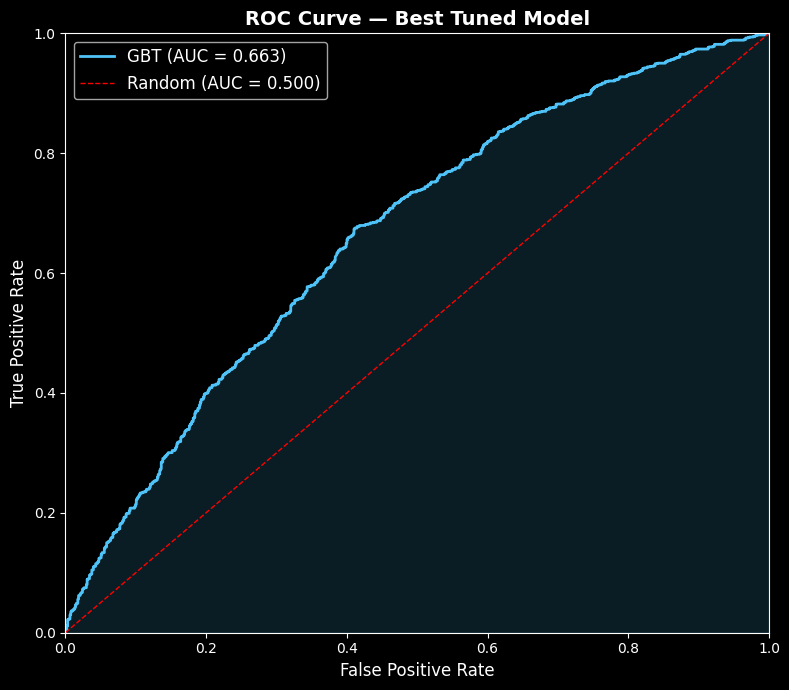

AUC Score: 0.6627
An AUC of 0.663 means the model ranks a random home-win game
above a random home-loss game 66.3% of the time.


In [25]:
# ── ROC Curve ────────────────────────────────────────────────────
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_proba_best)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8, 7))
ax.plot(fpr, tpr, color='#4FC3F7', lw=2, label=f'GBT (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], 'r--', lw=1, label='Random (AUC = 0.500)')
ax.fill_between(fpr, tpr, alpha=0.15, color='#4FC3F7')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve — Best Tuned Model', fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('10_roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"AUC Score: {roc_auc:.4f}")
print(f"An AUC of {roc_auc:.3f} means the model ranks a random home-win game")
print(f"above a random home-loss game {roc_auc:.1%} of the time.")

## Save Final Model & Summary

Save the best model along with metadata (features used, accuracy, params) so the backend can load and use it for predictions.

In [26]:
# ── Save Best Model ──────────────────────────────────────────────
MODEL_DIR = '/Users/akashkothari/Desktop/cxc/backend/model'
save_path = os.path.join(MODEL_DIR, 'nba_model_optimized.pkl')

model_bundle = {
    'model': best_model,
    'features': keep_cols,
    'params': best_params,
    'metrics': {
        'accuracy': best_acc,
        'temporal_accuracy': temp_acc,
        'auc': roc_auc,
        'f1': f1_score(y_test, y_pred_best),
        'total_games': len(raw),
        'train_games': len(X_train),
        'test_games': len(X_test),
    },
    'dropped_features': hurt_features,
    'seasons': sorted(raw['SEASON'].unique()),
}

with open(save_path, 'wb') as f:
    pickle.dump(model_bundle, f)

print(f"✅ Model saved to: {save_path}")
print(f"\n{'='*60}")
print(f"   FINAL MODEL SUMMARY")
print(f"{'='*60}")
print(f"  Algorithm:          GradientBoostingClassifier")
print(f"  Features:           {len(keep_cols)} (dropped {len(hurt_features)} noisy)")
print(f"  Training data:      {len(raw):,} games across {len(model_bundle['seasons'])} seasons")
print(f"  Random split acc:   {best_acc:.4f}")
print(f"  Temporal val acc:   {temp_acc:.4f}")
print(f"  AUC:                {roc_auc:.4f}")
print(f"  F1:                 {model_bundle['metrics']['f1']:.4f}")
print(f"  Naive baseline:     {raw['HOME_W'].mean():.4f}")
print(f"  Lift over naive:    +{best_acc - raw['HOME_W'].mean():.4f}")
print(f"{'='*60}")
print(f"\n  Features used:")
for i, f in enumerate(keep_cols, 1):
    print(f"    {i:2d}. {f}")
print(f"\n  Dropped features:")
for f in hurt_features:
    print(f"    ❌ {f}")

✅ Model saved to: /Users/akashkothari/Desktop/cxc/backend/model/nba_model_optimized.pkl

   FINAL MODEL SUMMARY
  Algorithm:          GradientBoostingClassifier
  Features:           12 (dropped 15 noisy)
  Training data:      10,231 games across 9 seasons
  Random split acc:   0.6292
  Temporal val acc:   0.6317
  AUC:                0.6627
  F1:                 0.6946
  Naive baseline:     0.5595
  Lift over naive:    +0.0697

  Features used:
     1. HOME_LAST_GAME_HOME_WIN_PCTG
     2. HOME_LAST_GAME_AWAY_WIN_PCTG
     3. HOME_NUM_REST_DAYS
     4. HOME_LAST_GAME_ROLLING_SCORING_MARGIN
     5. HOME_LAST_GAME_ROLLING_FG_PCT
     6. AWAY_LAST_GAME_AWAY_WIN_PCTG
     7. AWAY_NUM_REST_DAYS
     8. AWAY_LAST_GAME_ROLLING_OE
     9. AWAY_LAST_GAME_ROLLING_SCORING_MARGIN
    10. H2H_HOME_AVG_MARGIN
    11. HOME_ADVANTAGE
    12. FG_PCT_DIFF

  Dropped features:
    ❌ REST_DIFF
    ❌ SCORING_MARGIN_DIFF
    ❌ HOME_LAST_GAME_LAST_3_WINS
    ❌ H2H_HOME_WIN_PCT
    ❌ AWAY_IS_BACK_TO_BACK
    

## All Charts Summary

Generate a final combined figure for the presentation / frontend.

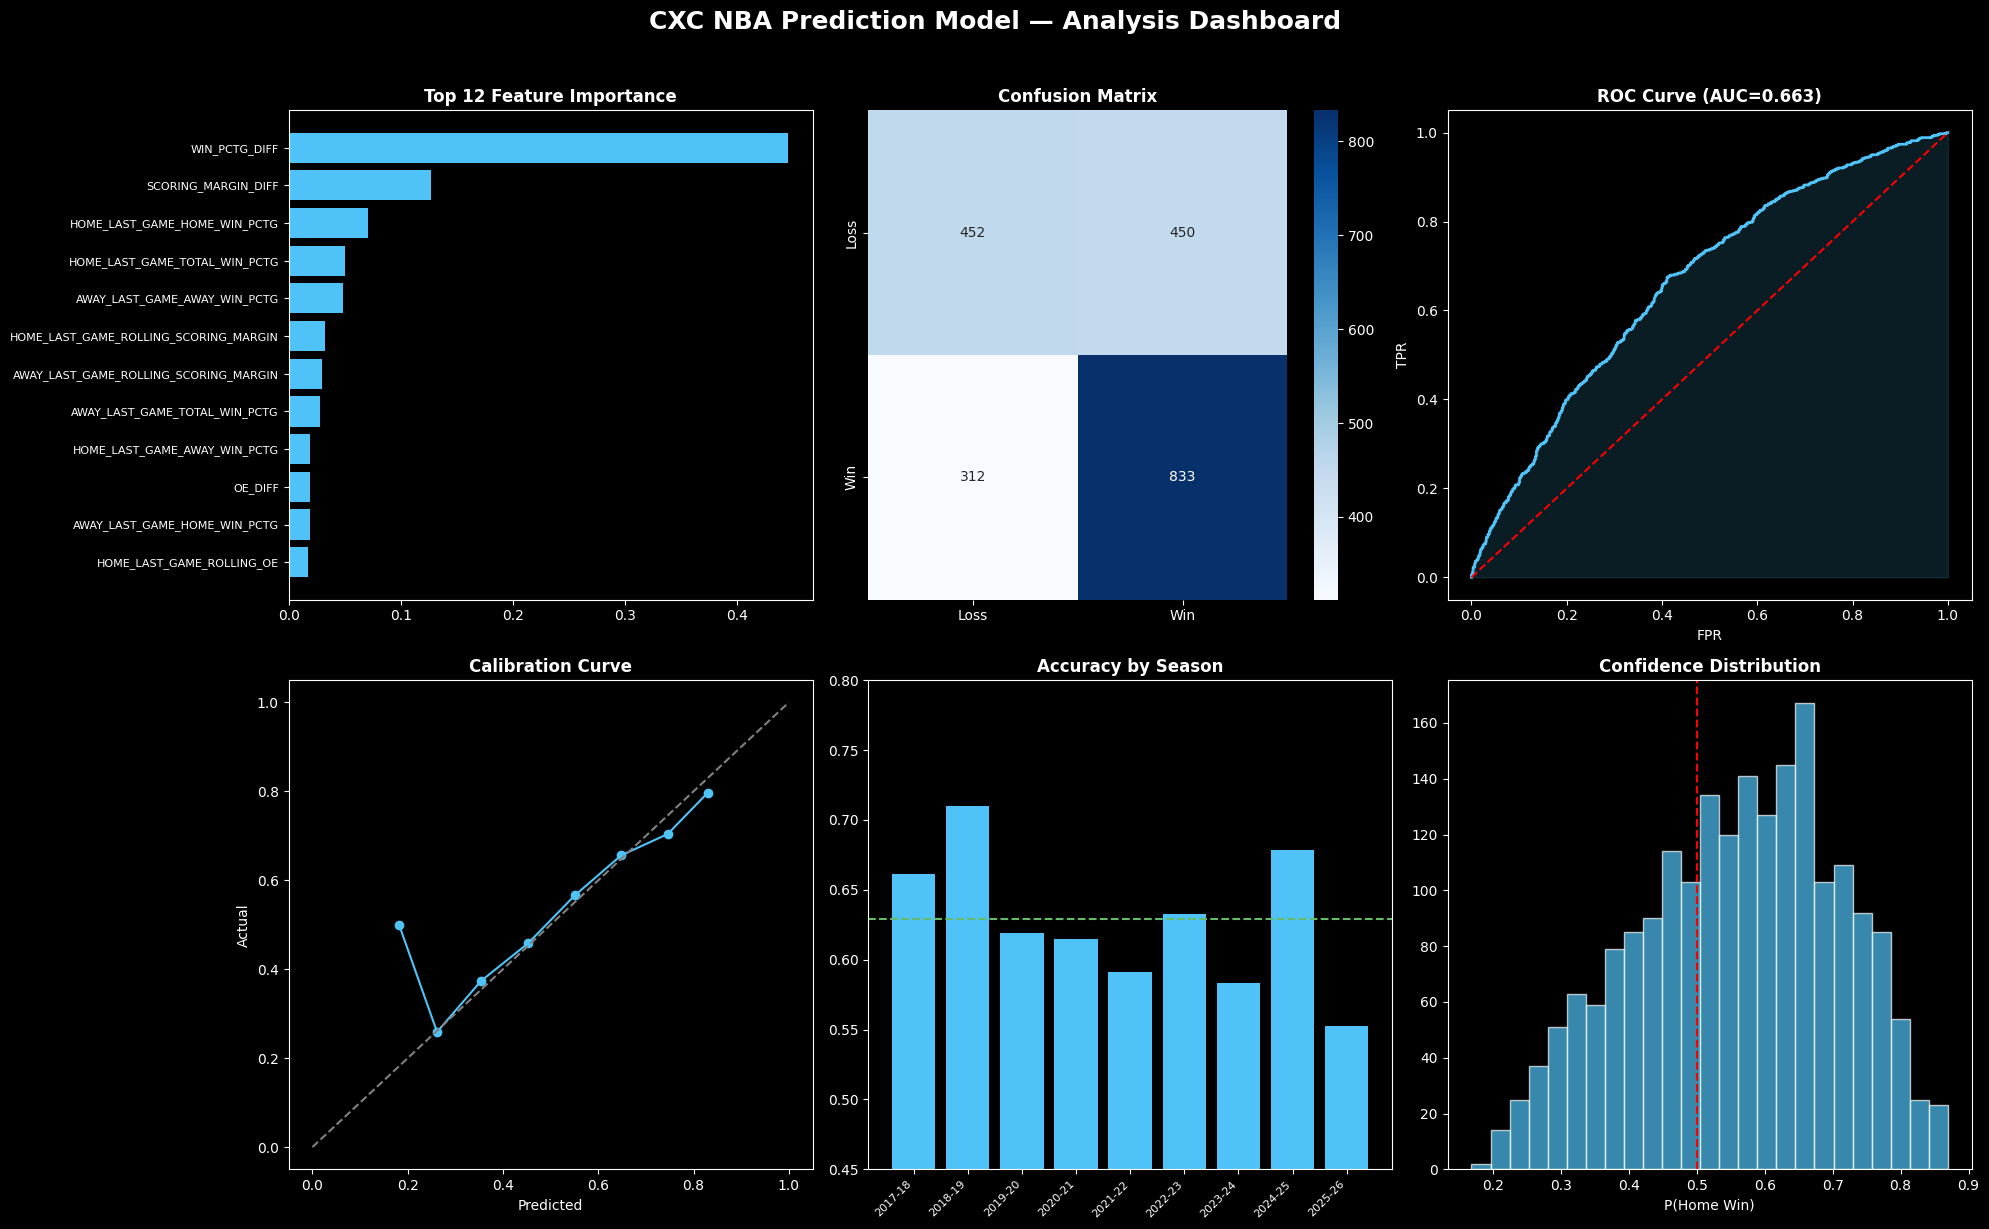

All charts saved as PNG files in notebooks/ directory.


In [27]:
# ── Final Dashboard Figure ───────────────────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('CXC NBA Prediction Model — Analysis Dashboard', fontsize=18, fontweight='bold', y=1.02)

# 1) Feature importance (top 12)
top_imp = importances.tail(12)
axes[0,0].barh(range(len(top_imp)), top_imp.values, color='#4FC3F7')
axes[0,0].set_yticks(range(len(top_imp)))
axes[0,0].set_yticklabels(top_imp.index, fontsize=8)
axes[0,0].set_title('Top 12 Feature Importance', fontweight='bold')

# 2) Confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,1],
            xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
axes[0,1].set_title('Confusion Matrix', fontweight='bold')

# 3) ROC
axes[0,2].plot(fpr, tpr, color='#4FC3F7', lw=2)
axes[0,2].plot([0, 1], [0, 1], 'r--')
axes[0,2].fill_between(fpr, tpr, alpha=0.15, color='#4FC3F7')
axes[0,2].set_title(f'ROC Curve (AUC={roc_auc:.3f})', fontweight='bold')
axes[0,2].set_xlabel('FPR')
axes[0,2].set_ylabel('TPR')

# 4) Calibration
axes[1,0].plot(prob_pred, prob_true, 'o-', color='#4FC3F7')
axes[1,0].plot([0, 1], [0, 1], '--', color='gray')
axes[1,0].set_title('Calibration Curve', fontweight='bold')
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('Actual')

# 5) Season accuracy
axes[1,1].bar(range(len(season_acc)), season_acc['accuracy'], color='#4FC3F7')
axes[1,1].axhline(best_acc, color='#66BB6A', linestyle='--')
axes[1,1].set_xticks(range(len(season_acc)))
axes[1,1].set_xticklabels(season_acc.index, rotation=45, ha='right', fontsize=8)
axes[1,1].set_title('Accuracy by Season', fontweight='bold')
axes[1,1].set_ylim(0.45, 0.80)

# 6) Confidence distribution
axes[1,2].hist(y_proba_best, bins=25, color='#4FC3F7', alpha=0.7, edgecolor='white')
axes[1,2].axvline(0.5, color='red', linestyle='--')
axes[1,2].set_title('Confidence Distribution', fontweight='bold')
axes[1,2].set_xlabel('P(Home Win)')

plt.tight_layout()
plt.savefig('11_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()
print("All charts saved as PNG files in notebooks/ directory.")